# MATH50003 (2024–25)
# Lab 9: VI.1 General Orthogonal Polynomials and VI.2 Classical Orthogonal Polynomials

This lab investigates the numerical construction of orthogonal polynomials, and
the practical usage of classical orthogonal polynomials. In particular, we can build orthogonal
polynomials using the Gram–Schmidt process, which can be simplified using the three-term recurrence
in the Stieltjes process. There is a special emphasis
on Chebyshev polynomials which are directly related to Cosine and Sine expansions.

**Learning Outcomes**

Mathematical knowledge:

1. Gram–Schmidt for continuous functions
2. Stieltjes procedure and three-term recurrences
3. Computing orthogonal polynomials via forward recurrence
4. Jacobi matrices including for orthonormal polynomials

Coding knowledge:

1. Updating a variable via the tuple syntax.

We use the following packages:

In [1]:
using QuadGK, Plots, LinearAlgebra, Test

## VI.1 General Orthogonal Polynomials

Orthogonal polynomials are graded polynomials which have the form
$$
p_n(x) = k_n x^n + k_n^{(1)} x^{n-1} + ⋯ + k_n^{(n-1)} x + k_n^{(n)}
$$
We can store the (currently unknown) coefficients of the orthogonal polynomials as an upper-triangular matrix:
$$
R_n = \begin{bmatrix} k_0 & k_1^{(1)} & k_2^{(2)} & ⋯ & k_n^{(n)} \\
              & k_1 & k_2^{(1)} & ⋯ & k_n^{(n-1)} \\
               &  & ⋱ & ⋱ & ⋮ \\
                & & & k_{n-1} & k_n^{(1)} \\
                  &&&& k_n
\end{bmatrix}
$$
This can be written as
$$
[p_0| …| p_n] = [1| x| …| x^n] R_n
$$

If we move $R_n$ to the otherside this can be viewed as a generalisation
of the QR factorisation:
$$
[1| x| …| x^n] = [p_0| …| p_n]  R_n^{-1}
$$
And just as Gram–Schmidt can be used to compute a QR factorisation of a matrix,
we can build monic orthogonal polynomials using a continuous version of Gram–Schmidt:
$$
 π_n(x) = x^n - ∑_{k=0}^{n-1} {⟨x^n,π_k ⟩ \over \|π_k\|^2} π_k(x).
$$
To deduce $R_n$ from this process we proceed as follows, assuming the inner product is
$$
⟨f,g⟩ := ∫_0^1 f(x) g(x) w(x) {\rm d}x
$$
which we approximate with `quadgk`:

In [2]:
function opgramschmidt(w, n)
    R = UpperTriangular(zeros(n,n)) # Connection matrix with monomials
    for j = 1:n
        R[j,j] = 1 # k_j = 1
        for k = 1:j-1
            πₖ = x -> R[1:k,k]'*[x^ℓ for ℓ=0:k-1] # the previously computed OP
            ip = quadgk(x -> x^(j-1) * πₖ(x) * w(x), 0, 1)[1] # ⟨x^n,π_k⟩
            nrm = quadgk(x -> πₖ(x)^2 * w(x), 0, 1)[1] # ||π_k||^2. A better version would store this as its repeating the computation for each j
            R[1:k,j] -= ip/nrm * R[1:k,k] # R[1:k,k] gives us the monomial expansion of πₖ
        end
    end
    R
end

opgramschmidt (generic function with 1 method)

For the special case of $w(x) = 1$ we get:

In [3]:
R = opgramschmidt(x -> 1, 5)

5×5 UpperTriangular{Float64, Matrix{Float64}}:
 1.0  -0.5   0.166667  -0.05   0.0142857
  ⋅    1.0  -1.0        0.6   -0.285714
  ⋅     ⋅    1.0       -1.5    1.28571
  ⋅     ⋅     ⋅         1.0   -2.0
  ⋅     ⋅     ⋅          ⋅     1.0

That is, we have computed the coefficients corresponding to
$$
\begin{align*}
π_0(x) &= 1, \\
π_1(x) &= x-1/2,\\
π_2(x) &= x^2 - x + 1/6,\\
π_3(x) &= x^3 - 3x^2/2 + 3x/5 - 1/20.
\end{align*}
$$
which we computed explicitly in the notes. We can use this to plot the OPs:

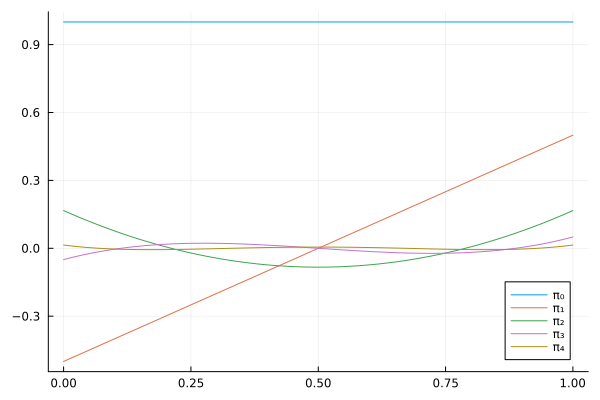

In [4]:
g = range(0,1,100) # plot grid
V = g .^ (0:4)' # Vandermonde matrix for monomials
plot(g, V*R; label=["π₀" "π₁" "π₂" "π₃" "π₄"])

----

**Problem 1(a)** Modify `opgramschmidt` to take in the support of the inner product $(α,β)$ and
not recompute $\|π_k\|^2$ multiple times, and return a tuple containing $R$ and a vector containing $\|π_0\|^2,…,\|π_{n-1}\|^2$.

In [5]:
function opgramschmidt(w, n, α, β)
    R = UpperTriangular(zeros(n,n)) # Connection matrix with monomials
    nrms = zeros(n) # vector of inner products
    # TODO: Modify the above code to support general weights and not recompute ||π_k||^2
    # SOLUTION
    for j = 1:n
        R[j,j] = 1 # k_j = 1
        for k = 1:j-1
            πₖ = x -> dot(R[1:k,k],[x^ℓ for ℓ=0:k-1]) # the previously computed OP
            ip = quadgk(x -> x^(j-1) * πₖ(x) * w(x), α, β)[1] # ⟨x^n,π_k⟩
            R[1:k,j] -= ip/nrms[k] * R[1:k,k] # R[1:k,k] gives us the monomial expansion of πₖ
        end
        πⱼ = x -> dot(R[1:j,j],[x^ℓ for ℓ=0:j-1]) # the previously computed OP
        nrms[j] =  quadgk(x -> πⱼ(x)^2 * w(x), α, β)[1]
    end
    # END
    R,nrms
end

R,nrms = opgramschmidt(x -> 1, 3, 0, 1)
@test R ≈ [1 -1/2 1/6;
           0  1   -1;
           0  0    1]
@test nrms ≈ [1,1/12,1/180]

Test Passed

**Problem 1(b)** Use the new `opgramschmidt` to compute the monic OPs for $\sqrt{1-x^2}$ and $1-x$ on $[-1,1]$
Do these match the computation from the problem sheet?

In [6]:
# TODO: employ the new opgramschmidt to the two examples from the problem sheet.
# SOLUTION
opgramschmidt(x -> sqrt(1-x^2), 5, -1, 1)[1]
# Yes it matches 1, x, x^2 - 1/4, x^3 - x/2
opgramschmidt(x -> 1-x, 5, -1, 1)[1]
# Yes it matches 1, x+1/3, x^2 + 2x/5 - 1/5, x^3 + 3x^2/7 - 3x/7 - 3/35
# END

5×5 UpperTriangular{Float64, Matrix{Float64}}:
 1.0  0.333333  -0.2  -0.0857143   0.047619
  ⋅   1.0        0.4  -0.428571   -0.190476
  ⋅    ⋅         1.0   0.428571   -0.666667
  ⋅    ⋅          ⋅    1.0         0.444444
  ⋅    ⋅          ⋅     ⋅          1.0

**Problem 1(c)** By calling `opgramschmidt` implement `orthonormalgramschmidt`
to return an upper triangular matrix containing the coefficents for
the orthonormal polynomials expanded in monomials. For the two examples in the previous problem,
does this match what you derived in the problem sheet?

In [7]:
function orthonormalgramschmidt(w, n, α, β)
    # TODO: Use opgramschmidt to construct the R for orthonormal polynomials
    # SOLUTION
    R,nrms = opgramschmidt(w, n, α, β)
    R * Diagonal(nrms .^ (-1/2))
    # END
end

R = orthonormalgramschmidt(x -> 1, 4, 0, 1)
@test R ≈ [1 -sqrt(3) sqrt(5)   -sqrt(7);
           0 2sqrt(3) -6sqrt(5) 12sqrt(7);
           0 0        6sqrt(5)  -30sqrt(7);
           0 0        0         20sqrt(7)]

Test Passed

-----

### VI.1.1 Three-term recurrence

Orthogonal polynomials all have three-term recurrences:
$$
\begin{align*}
x p_0(x) &= a_0 p_0(x) + b_0 p_1(x) \\
x p_n(x) &= c_{n-1} p_{n-1}(x) + a_n p_n(x) + b_n p_{n+1}(x).
\end{align*}
$$
We can use this fact to simplify the Gram-Schmidt process: we do not need
to orthogonalise against all $pₖ$ if instead of beginning with $x^k$ we begin with
$x pₖ$. Here we modify the code in `stieltjes` as this is called the _Stieltjes procedure_
(or sometimes _Lanczos_ which is the name of the corresponding finite-dimensional algorithm):

In [8]:
function stieltjes(w, n)
    if n < 2
        error("Only works for large enough n")
    end
    R = UpperTriangular(zeros(n,n)) # Connection matrix with monomials
    a = zeros(n-1) # aₖ
    c = zeros(n-2) # cₖ
    R[1,1] = 1

    # xπ_0 = a_0π_0 + π_1
    # a_0 = <xπ_0,1>/||π_0||^2
    a[1] = quadgk(x -> x*w(x), 0, 1)[1]/quadgk(w, 0, 1)[1]
    R[2,2] = 1 # coefficients of x*π_0
    R[1,2] = -a[1] # coefficients of -a_0*π_0
    for j = 2:n-1
        R[2:j+1,j+1] = R[1:j,j] # coefficients of x*πⱼ
        πⱼ = x -> R[1:j,j]'*[x^ℓ for ℓ=0:j-1] # π_ⱼ(x)
        πⱼ₋₁ = x -> R[1:j-1,j-1]'*[x^ℓ for ℓ=0:j-2] # π_ⱼ₋₁(x)

        # xπ_j = c_jπ_{j-1} + a_j*π_j + π_{j+1}
        c[j-1] = quadgk(x -> x*πⱼ(x)*πⱼ₋₁(x)*w(x), 0, 1)[1]/quadgk(x -> w(x)πⱼ₋₁(x)^2, 0, 1)[1]
        R[1:j-1,j+1] -= c[j-1]*R[1:j-1,j-1] # coefficients of -c_{j-1}*π_{j-1}
        a[j] = quadgk(x -> x*πⱼ(x)^2*w(x), 0, 1)[1]/quadgk(x -> w(x)πⱼ(x)^2, 0, 1)[1]
        R[1:j,j+1] -= a[j]*R[1:j,j] # coefficients of -a_j*π_j
    end
    R, a, c
end

R, a, c = stieltjes(x -> 1, 5)
@test R ≈ opgramschmidt(x -> 1, 5)

Test Passed

Knowing the three-term recurrence actually gives us an explicit formula for the the OPs themselves.
here is a simple example of evaluating monic OPs:

In [9]:
function monicforward(n, a, c, x)
    πₖ₋₁ = 1.0
    if n == 0
        return πₖ₋₁
    end
    πₖ = x - a[1]

    for k = 2:n
        πₖ,πₖ₋₁ = (x-a[k])*πₖ - c[k-1]*πₖ₋₁,πₖ # a little tuple trick to reuse variables! The RHS is evaluated first and then the variables are updated
    end
    πₖ
end

x = 0.1
@test monicforward(3, a, c, x) ≈ x^3 - 3x^2/2 + 3x/5 - 1/20 # matches explicit formula

Test Passed

----

**Problem 2(a)** Implement `orthonormalstieltjes` for computing the orthonormal polynomials,
to return an upper triangular matrix containing the coefficents for
the orthonormal polynomials expanded in monomials and the 3-term recurrences as vectors,
noting that $c_j = b_j$.

In [10]:
function orthonormalstieltjes(w, n, α, β)
    if n < 2
        error("Only works for large enough n")
    end
    R = UpperTriangular(zeros(n,n)) # Connection matrix with monomials
    a = zeros(n-1) # aₖ
    b = zeros(n-1) # bₖ

    R[1,1] = 1/sqrt(quadgk(w, α, β)[1])

    # TODO: complete the implementation populating R, a, b and c.
    # SOLUTION
    # xq_0 = a_0q_0 + b_0q_1
    # first build p_1 via
    # xq_0 = a_0q_0 + p_1
    # then divide by ||p_1||.
    a[1] = quadgk(x -> x*w(x)*R[1,1]^2, α, β)[1]

    R[2,2] = R[1,1] # coefficients of x*q_0
    R[1,2] = -a[1]*R[1,1] # coefficients of -a_0*q_0
    p₁ = x -> R[1,2] + R[2,2]*x
    b[1] = sqrt(quadgk(x -> w(x)*p₁(x)^2, α, β)[1])
    R[:,2] /= b[1] # divide by ||p₁||

    for j = 2:n-1
        R[2:j+1,j+1] = R[1:j,j] # coefficients of x*qⱼ
        qⱼ = x -> R[1:j,j]'*[x^ℓ for ℓ=0:j-1] # qⱼ(x)
        qⱼ₋₁ = x -> R[1:j-1,j-1]'*[x^ℓ for ℓ=0:j-2] # qⱼ₋₁(x)

        # xq_j = b_{j-1}q_{j-1} + a_j*q_j + p_{j+1}
        R[1:j-1,j+1] -= b[j-1]*R[1:j-1,j-1] # coefficients of -b_{j-1}*q_{j-1}
        a[j] = quadgk(x -> x*qⱼ(x)^2*w(x), α, β)[1]
        R[1:j,j+1] -= a[j]*R[1:j,j] # coefficients of -a_j*p_j
        pⱼ₊₁ = x -> R[1:j+1,j+1]'*[x^ℓ for ℓ=0:j] # pⱼ₊₁(x)
        b[j] = sqrt(quadgk(x -> w(x)*pⱼ₊₁(x)^2, α, β)[1]) # ||pⱼ₊₁||
        R[:,j+1] /= b[j]  # divide by ||pⱼ₊₁||
    end
    ## END
    R, a, b
end

R, a, b = orthonormalstieltjes(x -> 1, 5, 0, 1)
@test R ≈ orthonormalgramschmidt(x -> 1, 5, 0, 1)
@test a ≈ fill(0.5,4)
@test b[1:3] ≈ [1/(2sqrt(3)), 1/sqrt(15), 3/(2*sqrt(35))]

Test Passed

**Problem 2(b)** Implement `forward` for supporting general 3-term recurrences.

In [11]:
function forward(n, a, b, c, x, p₀)
    if n == 0
        return p₀
    end

    # TODO: implement forward recurrence to compute pₙ, given the recurrence coefficients a,b,c, x and
    # initial polynomial p₀ as a constant
    # SOLUTION
    pₖ₋₁ = p₀
    pₖ = (x-a[1])*p₀/b[1]

    for k = 2:n
        pₖ,pₖ₋₁ = ((x-a[k])*pₖ - c[k-1]*pₖ₋₁)/b[k],pₖ # a little tuple trick to reuse variables! The RHS is evaluated first and then the variables are updated
    end
    pₖ
    # END
end

@test forward(3, a, b, b, 0.1, R[1,1]) ≈ sqrt(7) * (20x^3 - 30x^2 + 12x - 1)

Test Passed

---

## VI.1.2 Jacobi matrices

The recurrence coefficients can be incorporated into an infinite-dimensional tridiagonal
matrix
$$
X = \begin{bmatrix} a_0 & c_0 \\ b_0 & a_1 & c_1 \\ & b_1 & a_2 & ⋱ \\
&&⋱ & ⋱
\end{bmatrix}
$$
representing multiplication by $x$. Here is a finite truncation of
the multiplication matrix:

In [12]:
n = 10
R, a, c = stieltjes(x -> 1, n+1)
X = Tridiagonal(ones(n-1), a, c) # Transpose of the Jacobi matrix

10×10 Tridiagonal{Float64, Vector{Float64}}:
 0.5  0.0833333   ⋅          ⋅         …   ⋅          ⋅          ⋅ 
 1.0  0.5        0.0666667   ⋅             ⋅          ⋅          ⋅ 
  ⋅   1.0        0.5        0.0642857      ⋅          ⋅          ⋅ 
  ⋅    ⋅         1.0        0.5            ⋅          ⋅          ⋅ 
  ⋅    ⋅          ⋅         1.0            ⋅          ⋅          ⋅ 
  ⋅    ⋅          ⋅          ⋅         …   ⋅          ⋅          ⋅ 
  ⋅    ⋅          ⋅          ⋅            0.0628205   ⋅          ⋅ 
  ⋅    ⋅          ⋅          ⋅            0.5        0.0627451   ⋅ 
  ⋅    ⋅          ⋅          ⋅            1.0        0.5        0.0626935
  ⋅    ⋅          ⋅          ⋅             ⋅         1.0        0.5

We can test the validity of the Jacobi matrix here:

In [13]:
x = 0.1
P = [monicforward(k, a, c, x) for k=0:n-1]'
@test x*P[:,1:n-1] ≈ P*X[:,1:n-1] # drop last column as X is trunctated

Test Passed

We can use this matrix to also deduce other polynomials:

In [14]:
x = 0.1
@test (x^2+x+1)*P[:,1:n-2] ≈ P*(X^2+X+I)[:,1:n-2] # drop an extra column as truncation of X impacts more entries of X^2

Test Passed

-----

**Problem 3** Complete the following function which takes in a multiplication matrix for a monic orthogonal polynomial
and returns the symmetric tridiagonal Jacobi matrix corresponding to the orthonormal polynomials.

In [15]:
function symmetrise(X::Tridiagonal)
    n = size(X,1)
    for j = 1:n-1
        if X[j+1,j] ≠ 1
            error("not a monic multiplication matrix")
        end
    end

    # TODO: return a SymTridiagonal with the Jacobi matrix of the corresponding orthonormal polynomials.
    # SOLUTION
    ## We implement the procedure from Example 24
    k = zeros(n)
    k[1] = 1 # The normalisation for q_0(x) doesn't impact the Jacobi matrix
    for j = 1:n-1
        k[j+1] = k[j]/sqrt(X[j,j+1])
    end
    SymTridiagonal(X.d,  k[1:n-1] ./ k[2:n])
    # END
end

J = symmetrise(X)
@test J isa SymTridiagonal
@test J[1:4,1:4] ≈ SymTridiagonal(fill(1/2,4), [1/(2sqrt(3)), 1/sqrt(15), 3/(2sqrt(35))])

Test Passed

## VI.2 Classical Orthogonal Polynomials

Classical orthogonal polynomials are special cases of orthogonal polynomials with a wide number of beautiful
properties. For us the primary usage is that the recurrence relationships can be computed explicitly: we do not
need to use Gram–Schmidt or Stietjes.

## VI.2.1 Chebyshev polynomials

Chebyshev polynomials are orthogonal on $[-1,1]$ with respect to $w(x) = 1/\sqrt{1-x^2}$.
They actually have an explicit formula as $T_n(x) = \cos n{\rm acos}\, x$. We can plot the first 5:

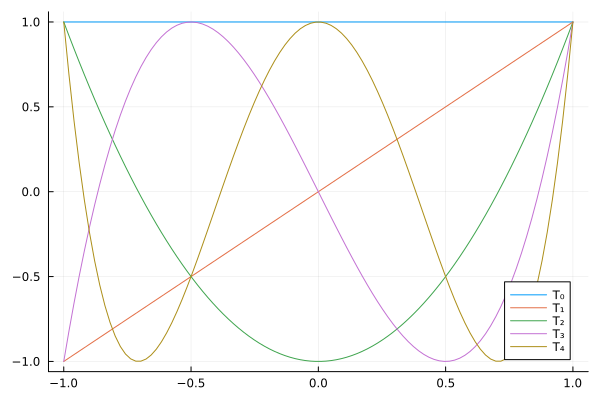

In [16]:
g = range(-1,1,100) # plot grid
plot(g, cos.((0:4)' .* acos.(g)); label=["T₀" "T₁" "T₂" "T₃" "T₄"])

These satisfy a simple 3-term recurrence:
$$
\begin{align*}
x T_0(x) &= T_1(x) \\
x T_n(x) &= T_{n-1}(x)/2 + T_{n+1}(x)/2
\end{align*}
$$
The recurrence gives us a way of computing $T_n(x)$ without the need for expensive
trigonometric functions used in the explicit formula:

In [17]:
function chebyshevt(n, x)
    Tₖ₋₁ = 1.0
    if n == 0
        return Tₖ₋₁
    end
    Tₖ = x
    for k = 1:n-1
        Tₖ,Tₖ₋₁ = 2x*Tₖ - Tₖ₋₁, Tₖ
    end
    Tₖ
end

x = 0.1
@test chebyshevt(10, x) ≈ cos(10*acos(x))

Test Passed

This is particularly useful if you need _all_ of $T_0(x),…,T_n(x)$, eg., to evaluate
a Chebyshev expansion, as we can save the values in a vector.

------

**Problem 4(a)**  A Chebyshev expansion is the same as a Cosine expansion of $f(\cos θ)$. Use
`discretecosinecoefficient` from the previous lab to implement `discretechebyshevcoefficient`
for computing Chebyshev expansion coefficients.

In [18]:
function discretecosinecoefficient(f, k, n)
    ret = 0.0
    for j = 1:n
        θⱼ = π*(j-1/2)/n
        ret = ret + f(θⱼ)*cos(k*θⱼ)
    end
    if k == 0
        ret/n
    else
        2ret/n
    end
end

function discretechebyshevcoefficient(f, k, n)
    # TODO: Use discretecosinecoefficient to approximate the Chebyshev coefficients of f
    # SOLUTION
    discretecosinecoefficient(θ -> f(cos(θ)), k, n)
    # END
end

n = 15
c = [discretechebyshevcoefficient(exp, k, n) for k=0:n-1]
x = 0.1
T = chebyshevt.(0:n-1,x)' # Chebyshev T
@test T*c ≈ exp(x)

Test Passed

**Problem 4(b)** In the problem sheet we saw that $T_n'(x) = n U_{n-1}(x)$. Use this to approximate the
derivative of a function.

In [19]:
function chebyshevdifferentiation(f, n, x)
    # TODO: Use discretechebyshevcoefficient and the derivative relationship to approximate the derivative of f,
    # using a Chebyshev expansion of f up to degree n-1
    # SOLUTION
    c = [discretechebyshevcoefficient(f, k, n) for k=0:n-1]
    U = [sin(k*acos(x))/sin(acos(x)) for k=1:n-1]' # U_k(x) for k=0…n-2
    U * ((1:n-1) .* c[2:end])
    # END
end

@test chebyshevdifferentiation(cos, 15, 0.1) ≈ -sin(0.1)

Test Passed

-----

## VI.2.2 Legendre polynomials

Legendre polynomials are orthogonal on $[-1,1]$ with respect to the constant (Lebesgue) weight,
with 3-term recurrence
$$
\begin{align*}
xP_0(x) &= P_1(x) \\
(2n+1) xP_n(x) &= nP_{n-1}(x) + (n+1)P_{n+1}(x).
\end{align*}
$$
For most computational problems Chebyshev expansions are more effective since they have fast transforms
via the connected with Cosine expansions and the Fast Fourier Transform. But Legendre polynomials have
some useful properties that make them very useful in certain settings (computing singular integrals is an
an example from my own research).

----

**Problem 5** Use the recurrence to compute Legendre polynomials $P_n(x)$.

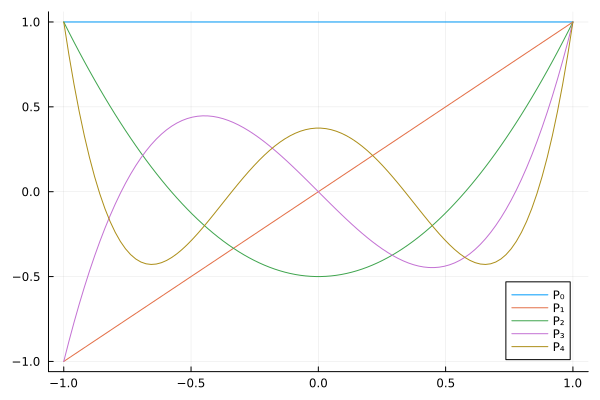

In [20]:
function legendrep(n, x)
    # TODO: Implement Legendre P_n(x) using the 3-term recurrence
    # SOLUTION
    Pₖ₋₁ = 1.0
    if n == 0
        return Pₖ₋₁
    end
    Pₖ = x
    for k = 1:n-1
        Pₖ,Pₖ₋₁ = (2k+1)/(k+1) * x*Pₖ - k/(k+1)*Pₖ₋₁, Pₖ
    end
    Pₖ
    # END
end

g = range(-1,1,100)
plot(g, legendrep.((0:4)', g); label=["P₀" "P₁" "P₂" "P₃" "P₄"])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*